# Predicting Mortgage Delinquency Risk

You have been hired by a mortgage servicing firm (a company that buys mortgages and then collects mortgage payments from homeowners) to build a model to answer the question: 

**Given all available information about a newly issued mortgage, what is the likelihood that the mortgage will enter delinquency (the homeowner will be at least 30 days late on a mortgage payment) during the first two years of the mortgage?**

The servicer's hope, obviously, is to differentiate between mortgages to try and purchase (those that will be consistently paid) and mortgages they wish to avoid.

For this task, you have been given [REAL data on a sample of all US Standard single family home mortgages purchased or insured by Freddie Mac](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset) in a single calendar year along with payment data from that and two subsequent years.

## WARNING

**This is a longer assignment than many you are accustomed to if you were in IDS 720. Please start early!**


## Gradescope Autograding

Please follow [all standard guidance](https://www.practicaldatascience.org/ids720_specific/autograder_guidelines.html) for submitting this assignment to the Gradescope autograder, including storing your solutions in a dictionary called `results` and ensuring your notebook runs from the start to completion without any errors.

For this assignment, please name your file `exercise_passive_prediction.ipynb` before uploading.

You can check that you have answers for all questions in your `results` dictionary with this code:

```python
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex5_num_mortgages",
    "ex5_share_delinquent",
    "ex7_num_obs",
    "ex10_predicted_delinquent",
    "ex11_share_delinquent_weighted",
    "ex13_optimal_threshold",
    "ex14_normalized_value",
    "ex15_num_obs",
    "ex15_share_delinquent",
    "ex16_final_return_pct",
    "ex16_normalized_value_2007",
}
```


### Submission Limits

Please remember that you are **only allowed THREE submissions to the autograder.** Your last submission (if you submit 3 or fewer times), or your third submission (if you submit more than 3 times) will determine your grade Submissions that error out will **not** count against this total.


### Good Notebook Practices

Please also review and follow all [Good Jupyter Notebook Practices](https://www.practicaldatascience.org/notebooks/PDS_not_yet_in_coursera/20_programming_concepts/writing_good_jupyter_notebooks.html) guidelines. They ARE grade relevant.

## Data Cleaning and Organization

Data for this exercise can be [found here](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2004). This folder includes both the data to be used and documentation, though you can find [supplemental documentation here](https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset).

The only modifications I've made to this data are:

- Subset to mortgages taken out for purchase of a property,
- With first payments due in the quarter of origination or the first quarter after origination (the vast majority of loans have first payments due the month after origination, so this just gets rid of some very weird mortgages).
- I have also excluded mortgages for which origination data is available but servicing data is not available in the two years following the year of origination.
- I also subset the data on servicing to the first 24 months after the mortgages first payment is due, so for each mortgage you will only have data on what happened in the first 24 months of its life.

However, post-subsetting I have done my best to convert the data back to the original format to make your experience working with the data as authentic as possible.

### Exercise 1

Begin by loading both: 

- the mortgage origination file (`sample_orig_2004_standard_mortgages.txt.zip`). This *should* contain information on all mortgages issued in 2004, along with non-time varying features of these mortgages (the initial amount, the credit score of the applicant, etc.), and 
- the servicing data (`sample_svcg_2004_threeyears_standard_mortgages.txt.zip`). This contains monthly records of all recorded payments (or non-payments) for all mortgages issued in 2004 during the calendar years of 2004, 2005, and 2006. As noted above, this has also been subset to only include the first 24 months after the first payment was due (though Freddie Mac has some data cleanliness issues, so sometimes there will be less than 24 records covering that first 24 months).

So the autograder can see the data, be sure to load it directly from a URL (don't download and load from your own system).

Because this is **real** data, it has some issues (even beyond what I've cleaned above). While I generally love to leave students to work through this stuff, this is a long exercise, so here are a couple tips:

- The data is zip compressed. When you gives pandas a zip file that has only one thing in the zip archive, it will *usually* infer what's going on and decompress it without help. However, if the file name or URL you pass to pandas does not end in `.zip`, this automatic inference will fail and you will need to use the `compression` keyword to explicitly tell pandas the file is zip compressed.
- When you load the data, you will see it does not have column names. You will likely need to reference the documentation to figure out appropriate column names.
  - pandas will automatically treat the first row of a dataset as column names, not data. When working with a dataset that lacks column names, not only do you have to set the column names (so you know the meaning of each column), you also have to make sure pandas doesn't treat the first row as labels and not data (effectively dropping it).

In [59]:
import pandas as pd
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.copy_on_write", True)

results = {}

In [60]:
import pandas as pd

# Define URLs for the datasets
origination_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_orig_2004_standard_mortgages.txt.zip"
servicing_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2004/sample_svcg_2004_threeyears_standard_mortgages.txt.zip"

# Load the origination data
origination_df = pd.read_csv(
    origination_url, compression="zip", header=None, delimiter="|"
)

# Load the servicing data
servicing_df = pd.read_csv(servicing_url, compression="zip", header=None, delimiter="|")

# Display basic information about the datasets
origination_df.info(), servicing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17471 entries, 0 to 17470
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       17471 non-null  int64  
 1   1       17471 non-null  int64  
 2   2       17471 non-null  object 
 3   3       17471 non-null  int64  
 4   4       12655 non-null  float64
 5   5       17471 non-null  int64  
 6   6       17471 non-null  int64  
 7   7       17471 non-null  object 
 8   8       17471 non-null  int64  
 9   9       17471 non-null  int64  
 10  10      17471 non-null  int64  
 11  11      17471 non-null  int64  
 12  12      17471 non-null  float64
 13  13      17471 non-null  object 
 14  14      17471 non-null  object 
 15  15      17471 non-null  object 
 16  16      17471 non-null  object 
 17  17      17471 non-null  object 
 18  18      17471 non-null  int64  
 19  19      17471 non-null  object 
 20  20      17471 non-null  object 
 21  21      17471 non-null  int64  
 22

/var/folders/35/864rn6qs23n05rwx8x5t88700000gn/T/ipykernel_39459/3180582659.py:13: DtypeWarning: Columns (3,7,23) have mixed types. Specify dtype option on import or set low_memory=False.
  servicing_df = pd.read_csv(servicing_url, compression="zip", header=None, delimiter="|")


(None, None)

In [61]:
# map column names to data
origination_df.columns = [
    "credit_score",
    "first_payment_date",
    "first_time_homebuyer_flag",
    "maturity_date",
    "metropolitan_statistical_area_metropolitan_division",
    "mortgage_insurance_percentage",
    "no_of_units",
    "occupancy_status",
    "original_combined_loan_to_value",
    "original_debt_to_income_ratio",
    "original_UPB",
    "original_loan_to_value",
    "original_interest_rate",
    "channel",
    "prepayment_penalty_mortgage_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "postal_code",
    "loan_sequence_number",
    "loan_purpose",
    "original_loan_term",
    "number_of_borrowers",
    "seller_name",
    "service_name",
    "super_conforming_flag",
    "pre_relief_refiance_loan_sequence_number",
    "program_indicator",
    "relief_refinance_indicator",
    "property_valuation_method",
    "interest_only_indicator",
    "MI_cancellation_indicator",
]
servicing_df.columns = [
    "loan_sequence_number",
    "monthly_reporting_period",
    "current_actual_UPB",
    "current_loan_delinquency_status",
    "loan_age",
    "remaining_months_to_legal_maturity",
    "defect_settlement_date",
    "modification_flag",
    "zero_balance_code",
    "zero_balance_effective_date",
    "current_interest_rate",
    "current_non_interest_bearing_UPB",
    "due_date_last_paid_installment",
    "MI_recoveries",
    "net_sale_proceeds",
    "non_MI_recoveries",
    "total_expenses",
    "legal_costs",
    "maintenance_and_preservation_costs",
    "taxes_and_insurance",
    "miscellaneous_expenses",
    "actual_loss_calculation",
    "cumulative_modification_cost",
    "step_modification_flag",
    "payment_deferral",
    "estimated_loan_to_value",
    "zero_balance_removal_UPB",
    "delinquent_accrued_interest",
    "delinquency_due_to_disaster",
    "borrower_assistance_status_code",
    "current_month_modification_cost",
    "interest_bearing_UPB",
]

In [62]:
# ensure data has column names
origination_df.head(10)

,credit_score,first_payment_date,first_time_homebuyer_flag,maturity_date,metropolitan_statistical_area_metropolitan_division,mortgage_insurance_percentage,no_of_units,occupancy_status,original_combined_loan_to_value,original_debt_to_income_ratio,...,number_of_borrowers,seller_name,service_name,super_conforming_flag,pre_relief_refiance_loan_sequence_number,program_indicator,relief_refinance_indicator,property_valuation_method,interest_only_indicator,MI_cancellation_indicator
0,653,200403,Y,203402,20740.0,17,1,P,87,25,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
1,747,200403,N,203402,30700.0,0,2,I,70,34,...,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
2,731,200403,N,201902,NaN,0,1,P,80,40,...,2,"PROVIDENT FUNDING ASSOCIATES, L.P.","PROVIDENT FUNDING ASSOCIATES, L.P.",NaN,NaN,9,NaN,9,N,9
3,682,200403,N,201902,NaN,0,1,P,80,30,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
4,730,200403,N,203402,NaN,0,1,P,80,30,...,1,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
5,791,200403,N,203402,45060.0,0,1,P,80,999,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
6,739,200403,N,202402,NaN,0,1,P,80,21,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
7,761,200403,N,203402,36740.0,0,1,S,80,999,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
8,793,200403,N,201902,NaN,0,1,P,24,28,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9
9,770,200403,N,203402,NaN,0,1,P,73,29,...,2,Other sellers,Other servicers,NaN,NaN,9,NaN,9,N,9


In [63]:
servicing_df.head(15)

,loan_sequence_number,monthly_reporting_period,current_actual_UPB,current_loan_delinquency_status,loan_age,remaining_months_to_legal_maturity,defect_settlement_date,modification_flag,zero_balance_code,zero_balance_effective_date,...,cumulative_modification_cost,step_modification_flag,payment_deferral,estimated_loan_to_value,zero_balance_removal_UPB,delinquent_accrued_interest,delinquency_due_to_disaster,borrower_assistance_status_code,current_month_modification_cost,interest_bearing_UPB
0,F04Q10000054,200403,126000.00,0,1,359,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
1,F04Q10000054,200404,126000.00,0,2,358,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
2,F04Q10000054,200405,126000.00,0,3,357,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
3,F04Q10000054,200406,126000.00,0,4,356,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
4,F04Q10000054,200407,126000.00,0,5,355,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
5,F04Q10000054,200408,126000.00,0,6,354,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126000.00
6,F04Q10000054,200409,125613.57,0,7,353,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125613.57
7,F04Q10000054,200410,125484.37,0,8,352,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125484.37
8,F04Q10000054,200411,125354.52,0,9,351,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125354.52
9,F04Q10000054,200412,125224.02,0,10,350,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125224.02


### Exercise 2

What is the unit of observation in `sample_orig_2004_standard_mortgages.txt` and in `sample_svcg_2004_threeyears_standard_mortgages.txt`?

**1. For ``sample_orig_2004_standard_mortgages.txt``, the unit of observation is loan-level origination information for every loan originated during the quarter.**  
**2. For ``sample_svcg_2004_threeyears_standard_mortgages.txt``, the unit of observation is monthly loan-level credit performance and actual loss data for each loan, starting from the time of loan acquisition by Freddie Mac until the earlier of a termination event or the Performance Cutoff Date.**

### Exercise 3

Merge your two datasets. Be sure to use the `validate` keyword argument in `merge`.

You will find some records in the origination files not in the servicing file. We need data from both files, so just do an `inner` join.

Assuming that you list the data associated with `sample_orig_2004_standard_mortgages.txt` first and `sample_svcg_2004_threeyears_standard_mortgages.txt` second, what keyword are you passing to `validate`? Store your answer as a string (use one of: `"1:1"`, `"m:1"`, `"1:m"`, `"m:m"`) in a dictionary called `results` under the key `ex2_merge_type`.

In [64]:
# merge the two datasets
merged_df = pd.merge(
    origination_df,
    servicing_df,
    on="loan_sequence_number",
    how="inner",
    validate="one_to_many",
)
results["ex2_merge_type"] = "1:m"

# print the type of merge used
print(f"The type of merge used is {results['ex2_merge_type']}")

The type of merge used is 1:m


### Exercise 4

For each unique mortgage in your dataset, create an indicator variable that takes on a value of 1 if, at any time during this period, the mortgage has been delinquent.

Delinquency status is stored in the variable `CURRENT LOAN DELINQUENCY STATUS`, and is coded as:

> CURRENT LOAN DELINQUENCY STATUS – A value corresponding to the number of days the borrower is delinquent, based on the due date of last paid installment (“DDLPI”) reported by servicers to Freddie Mac, and is calculated under the Mortgage Bankers Association (MBA) method.
If a loan has been acquired by REO, then the Current Loan Delinquency Status will reflect the value corresponding to that status (instead of the value corresponding to the number of days the borrower is delinquent).
>
> 0 = Current, or less than 30 days delinquent
> 
> 1 = 30-59 days delinquent
> 
> 2=60–89days delinquent
> 
> 3=90–119days delinquent
> 
> And so on...
> 
> RA = REO Acquisition


In [65]:
merge_df_ex4 = merged_df.copy()

# clean the variable
merge_df_ex4["current_loan_delinquency_status"] = pd.to_numeric(
    merge_df_ex4["current_loan_delinquency_status"], errors="coerce"
).fillna(0)
merge_df_ex4.loc[
    merge_df_ex4["current_loan_delinquency_status"] == "RA",
    "current_loan_delinquency_status",
] = 999

# create the indicator variable for delinquency
# group by 'loan_sequence_number' and check if any status is greater than 0 (delinquent)
delinquency_indicator = (
    merge_df_ex4.groupby("loan_sequence_number")["current_loan_delinquency_status"]
    .apply(lambda x: 1 if any(x > 0) else 0)
    .reset_index()
)
delinquency_indicator.rename(
    columns={"current_loan_delinquency_status": "delinquency_indicator"}, inplace=True
)

# deliqneuncy_indicator = 1 denotes delinquent loans
filtered_merge_df_ex4 = pd.merge(
    merge_df_ex4, delinquency_indicator, on="loan_sequence_number"
)

### Exercise 5

At this point, you should be able to drop all servicing variables reported on a monthly basis and just keep information about the original mortgage issuance (and still keep an indicator for whether the mortgage has ever been delinquent).

Store the final number of mortgages in your data under `ex5_num_mortgages` and the share (between 0 and 1) of mortgages that have been delinquent under `ex5_share_delinquent`. **Please round the share delinquent to 3 decimal places.**

In [66]:
columns_to_drop = [
    "current_loan_delinquency_status",
    "monthly_reporting_period",
    "loan_age",
    "current_actual_UPB",
    "remaining_months_to_legal_maturity",
    "defect_settlement_date",
    "modification_flag",
    "zero_balance_code",
    "zero_balance_effective_date",
    "current_interest_rate",
    "current_non_interest_bearing_UPB",
    "due_date_last_paid_installment",
    "MI_recoveries",
    "net_sale_proceeds",
    "non_MI_recoveries",
    "total_expenses",
    "legal_costs",
    "maintenance_and_preservation_costs",
    "taxes_and_insurance",
    "miscellaneous_expenses",
    "actual_loss_calculation",
    "cumulative_modification_cost",
    "step_modification_flag",
    "payment_deferral",
    "estimated_loan_to_value",
    "zero_balance_removal_UPB",
    "delinquent_accrued_interest",
    "delinquency_due_to_disaster",
    "borrower_assistance_status_code",
    "current_month_modification_cost",
    "interest_bearing_UPB",
]

# drop the specified columns from the DataFrame
final_df = filtered_merge_df_ex4.drop(columns=columns_to_drop, axis=1)
# drop duplicates in final_df
final_df = final_df.drop_duplicates(subset="loan_sequence_number")
# get the number of mortgages and the share of delinquent mortgages
final_df.reset_index(drop=True, inplace=True)


ex5_num_mortgages = len(final_df)


ex5_share_delinquent = final_df["delinquency_indicator"].sum() / ex5_num_mortgages


results["ex5_num_mortgages"] = ex5_num_mortgages


results["ex5_share_delinquent"] = round(ex5_share_delinquent, 3)
print(
    f"The number of mortgages is {results['ex5_num_mortgages']} and the share of delinquent mortgages is {results['ex5_share_delinquent']}"
)

The number of mortgages is 17471 and the share of delinquent mortgages is 0.071


## Modeling Delinquency Risk

Your data should now be relatively [tidy](https://vita.had.co.nz/papers/tidy-data.pdf), in the technical sense of the term. And that means it should be relatively straightforward for you to build a model that answers the question "Given the features of a newly originated mortgage, how likely is the mortgage holder to fall into delinquency within the first two years after origination?" to help your stakeholder decide which mortgages to purchase.

### Exercise 6

For your analysis, include the following variables: 

```
Credit Score
First Time Homebuyer Flag
Number of Units
Mortgage Insurance Percentage (MI %)
Occupancy Status
Original Debt-to-Income (DTI) Ratio
Original UPB
Original Loan-to-Value (LTV)
Original Interest Rate
Channel
Prepayment Penalty Mortgage (PPM) Flag
Amortization Type (Formerly Product Type)
Property State
Property Type
Original Loan Term
Number of Borrowers
```

Be sure to clean these variables. When doing so, please treat missing data as missing (e.g., `np.nan`, not as a distinct category). You will probably want to consult the documentation on the data for guidance on missing values.


### Why Aren't We Using Metropolitan Statistical Area (MSA)?

Metropolitan Statistical Area (MSA) is what the US Census Bureau calls what most people would think of as a city. Durham *plus* Chapel Hill are considered a single MSA, for example.

So looking at this list, you may be wondering why we aren't using the MSA variable in the data. After all, real estate is all about location, location, location, right? 

Well, the problem is the data is too sparse — it's missing for a substantial number of observations, and more importantly there are lots of MSAs with only a couple of observations that are delinquent (about 40% of MSAs have less than 4 mortgages that are delinquent in their first two years). That's just too sparse for modelling — when coefficients are being estimated for those categories, they're bound to over-fit.

Put differently: would you be comfortable estimating the delinquency rate for, say, the city of Denver, CO with three or fewer delinquent observations? Of course not, but when you try and predict values to new data, that's precisely what you're doing — applying an estimate of delinquency from a few delinquent observations to any new observations in that MSA.

If you were working with longer time periods or the dataset with *all* Freddie Mac mortgages (not a sample), you could probably use MSA.

In [67]:
# Update the final dataframe
final_df = final_df[
    [
        "credit_score",
        "first_time_homebuyer_flag",
        "no_of_units",
        "mortgage_insurance_percentage",
        "occupancy_status",
        "original_debt_to_income_ratio",
        "original_UPB",
        "original_loan_to_value",
        "original_interest_rate",
        "channel",
        "prepayment_penalty_mortgage_flag",
        "original_loan_term",
        "number_of_borrowers",
        "delinquency_indicator",
        "amortization_type",
        "property_state",
        "property_type",
        "loan_sequence_number",
    ]
]

# Verify the updated column list
final_df.columns

Index(['credit_score', 'first_time_homebuyer_flag', 'no_of_units',
       'mortgage_insurance_percentage', 'occupancy_status',
       'original_debt_to_income_ratio', 'original_UPB',
       'original_loan_to_value', 'original_interest_rate', 'channel',
       'prepayment_penalty_mortgage_flag', 'original_loan_term',
       'number_of_borrowers', 'delinquency_indicator', 'amortization_type',
       'property_state', 'property_type', 'loan_sequence_number'],
      dtype='object')

In [68]:
import numpy as np

# replace 9999 with np.nan in credit score
final_df["credit_score"] = final_df["credit_score"].replace(9999, np.nan)

# replace 9 with np.nan in first time homebuyer flag
final_df["first_time_homebuyer_flag"] = final_df["first_time_homebuyer_flag"].replace(
    "9", np.nan
)
# replace 999 with np.nan in mortgage insurance percentage, original debt to income ratio, original loan to value
final_df["mortgage_insurance_percentage"] = final_df[
    "mortgage_insurance_percentage"
].replace(999, np.nan)

# replace 99 in no of units
final_df["no_of_units"] = final_df["no_of_units"].replace(99, np.nan)

# replace 9 in occupancy status
final_df["occupancy_status"] = final_df["occupancy_status"].replace("9", np.nan)

final_df["original_debt_to_income_ratio"] = final_df[
    "original_debt_to_income_ratio"
].replace(999, np.nan)
final_df["original_loan_to_value"] = final_df["original_loan_to_value"].replace(
    999, np.nan
)

# replace 9 in channel, loan purpose, program indicator, property valuation method
final_df["channel"] = final_df["channel"].replace("9", np.nan)
# replace 99 in property type, number of borrowers
final_df[["property_type"]] = final_df[["property_type"]].replace("99", np.nan)
final_df["number_of_borrowers"] = final_df["number_of_borrowers"].replace(99, np.nan)

### Exercise 7

The next step in our analysis is to convert our categorical variables to one-hot-encodings and use `train_test_split` to split our data.

To ensure replicability, **before** you `train_test_split` your data, please sort your data by `Loan Sequence Number`. This will ensure when we split the data with a random seed below, everyone will get the same split and the autograder will function.

You may create your one-hot-encodings however you wish, but I'm a fan of the [patsy library's](https://patsy.readthedocs.io/en/latest/overview.html) `dmatrices` function.

**Hint:** You should end up with 8 categorical variables, including some binary flags and `Number_of_Borrowers`, `Number_of_Units` (which you could argue should be continuous, but I think are better treated as categorical).

**Hint 2:** To use `patsy`, you will probably need to make some changes to the names of your variables. To make your life easier, you may wish to use a little snippet like this:

```python
import re
mortgages_2004.columns = [re.sub(" ", "_", c) for c in mortgages_2004.columns]
mortgages_2004.columns = [re.sub("[%/()-]", "", c) for c in mortgages_2004.columns]
```

**Hint 3:** your final `X` matrix should have 76 columns, including intercept.

Store the number of observations in your final dataset in `ex7_num_obs`. 

In [69]:
# sort the final_df by loan_sequence_number
final_df_sorted = final_df.sort_values(by="loan_sequence_number")
import patsy

# create the design matrix
y, x = patsy.dmatrices(
    'Q("delinquency_indicator") ~ C(Q("first_time_homebuyer_flag")) + '
    'C(Q("no_of_units")) + C(Q("occupancy_status")) + C(Q("channel")) + '
    'C(Q("prepayment_penalty_mortgage_flag")) + C(Q("amortization_type")) + '
    'C(Q("property_state")) + C(Q("property_type")) + C(Q("number_of_borrowers")) + Q("credit_score") + '
    'Q("mortgage_insurance_percentage") + Q("original_debt_to_income_ratio") + '
    'Q("original_UPB") + Q("original_loan_to_value") + Q("original_interest_rate") + '
    'Q("original_loan_term")',
    final_df_sorted,
    return_type="dataframe",
)
# Get the number of observations
ex7_num_obs = len(x)

# Store the result
results["ex7_num_obs"] = ex7_num_obs

# Display the result
print(f"The number of observations is {results['ex7_num_obs']}")

The number of observations is 17052


In [70]:
# Check the number of columns in the X matrix
num_columns_x = x.shape[1]

# Display the result
print(f"The number of columns in the X matrix is: {num_columns_x}")

The number of columns in the X matrix is: 76


### Exercise 8

Use `train_test_split` from `sklearn.model_selection` to split the data. 

Before you do, Use `0.2` as the `test_size` and use `random_state=42`.

In [71]:
from sklearn.model_selection import train_test_split

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

### Exercise 9

Now fit a `GradientBoostingClassifier` to the data (from `sklearn.ensemble`). Set `random_state=42` when instantiating your `GradientBoostingClassifier`.


In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# fit a GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train.values.ravel())

# get predicted probabilities on the test data
y_pred_proba = gbc.predict_proba(X_test)[:, 1]

### Exercise 10

Use the `predict` method and your test data to generate a confusion matrix. 

What problem do you see with the result? Round the share of observations predicted to be delinquent to three decimal places and store them under `ex10_predicted_delinquent` in `results`.

In [73]:
from sklearn.metrics import confusion_matrix

# use predict method to get the predicted values
y_pred = gbc.predict(X_test)

# generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# convert the confusion matrix to a DataFrame
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Actual Non-Delinquent", "Actual Delinquent"],
    columns=["Predicted Non-Delinquent", "Predicted Delinquent"],
)

conf_matrix_df

,Predicted Non-Delinquent,Predicted Delinquent
Actual Non-Delinquent,3146,9
Actual Delinquent,252,4


**The high false positive rate means our model often wrongly predicts non-delinquent cases as delinquent. The model tends to overpredict positive cases, resulting in more instances of non-delinquent individuals being misclassified as delinquent.

In [74]:
# Extract values from the confusion matrix
predicted_delinquent = 9 + 4
total_observations = 3146 + 9 + 252 + 4

# Calculate share and round to 3 decimal places
ex10_predicted_delinquent = round(predicted_delinquent / total_observations, 3)

# Store in results dictionary
results["ex10_predicted_delinquent"] = ex10_predicted_delinquent

# Print result
print(
    f"Share of observations predicted to be delinquent: {results['ex10_predicted_delinquent']:.3f}"
)

Share of observations predicted to be delinquent: 0.004


### Exercise 11

With imbalanced data, it's not uncommon for classification algorithms to maximize performance by basically just predicting everything is the dominant class.

One way to help reduce this behavior is to re-weight the data so that each observation of the dominant class gets less weight and each observation in the minority class gets more. A common default approach is to weigh each class with the reciprocal of its share of the data (so if delinquencies were 5% of our observations, we would give each delinquent observation a weight of 1/0.05 = 20, and each non-delinquent observation a weight of 1/0.95 = 1.0526...).

To accomplish this, create an array with sample weights using this reciprocal rule for each observation and pass it to the `sample_weight` argument of `.fit()` and refit your model.

To help the autograder, please:

- Recalculate the share of observations that are delinquent and use the full calculated value to calculate weights, and
- Re-instantiate your `GradientBoostingClassifier` with `random_state=42`.

What share of observations are now predicted to be delinquent? Store the share under `ex11_share_delinquent_weighted` in `results`. **Round your answer to three decimal places.**

In [75]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Recalculate the share of delinquent observations
share_delinquent = np.mean(
    y_train
)  # Since y_train is binary (0/1), mean gives the proportion of 1s

# Compute class weights
weight_non_delinquent = 1 / (1 - share_delinquent)
weight_delinquent = 1 / share_delinquent

# Ensure y_train is a NumPy array and reshape if necessary
y_train = np.array(y_train).ravel()  # Ensure it's a 1D array

# Create a weight array with the correct shape (1D array with length equal to y_train)
sample_weights = np.where(
    y_train == 1, weight_delinquent, weight_non_delinquent
).flatten()

# Debugging: Check shape of sample_weights and y_train
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of sample_weights: {sample_weights.shape}")

# Re-instantiate and refit GradientBoostingClassifier with weights
gbc_weighted = GradientBoostingClassifier(random_state=42)
gbc_weighted.fit(X_train, y_train, sample_weight=sample_weights)

# Predict on test set
y_pred_weighted = gbc_weighted.predict(X_test)

# Generate new confusion matrix
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)

# Compute the new share of observations predicted as delinquent
predicted_delinquent_weighted = conf_matrix_weighted[0, 1] + conf_matrix_weighted[1, 1]
total_observations_weighted = conf_matrix_weighted.sum()
ex11_share_delinquent_weighted = round(
    predicted_delinquent_weighted / total_observations_weighted, 3
)

# Store in results dictionary
results["ex11_share_delinquent_weighted"] = ex11_share_delinquent_weighted

# Print result
print(
    f"Share of observations predicted to be delinquent (weighted): {results['ex11_share_delinquent_weighted']:.3f}"
)

Shape of y_train: (13641,)
Shape of sample_weights: (13641,)
Share of observations predicted to be delinquent (weighted): 0.298


### Exercise 12

As you can tell, these weights are obviously parameters than can be tuned, but for the moment let's stick with the results of our model fit with reciprocal weights.

A classification model like this will provide a default classification threshold, but we can also use `.predict_proba()` to get *probabilities* the model assigns to whether each observation is a `1`. This is helpful, because one thing we can do as data scientists is play with the probability threshold at which we call an observation a `1`. 

In other words, you can vary the threshold value `t` at which you say "for any observation with `.predict_proba()` above a value `t` is a 1, and any observation with a value below `t` is a 0." Then for each `t`, you will get a set of predicted classes for which you can calculate the resulting number of true and false positives and negatives.

(If you think in these terms, changing the sample weights we give the model will impact the orientation of the separating hyperplane the model creates to split the data; changing the classification threshold at which an observation is considered a `1` basically constitutes a simple shifting the hyperplane.)

Using the results of our `GradientBoostingClassifier` fit with reciprocal sample weights, get the predicted probabilities for each observation in our test data. 

Plot the share of observations classified as delinquent against classification thresholds from 0 to 1.

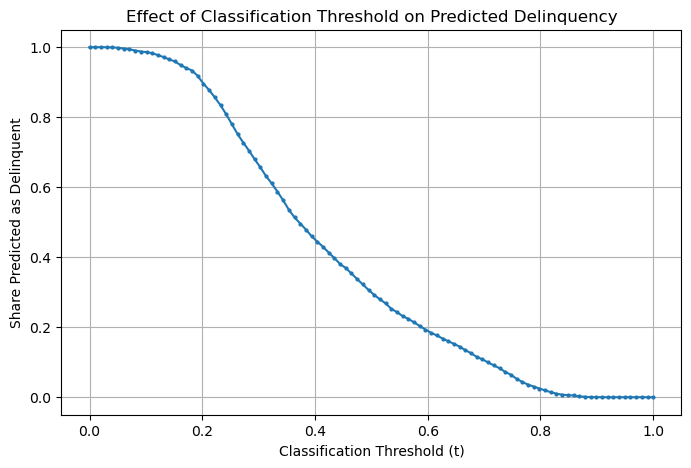

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Get predicted probabilities from the trained model
y_prob_weighted = gbc_weighted.predict_proba(X_test)[
    :, 1
]  # Probabilities for class 1 (delinquent)

# Define thresholds from 0 to 1 in steps of 0.01
thresholds = np.linspace(0, 1, 100)
share_predicted_delinquent = []

# Calculate the share of observations classified as delinquent for each threshold
for t in thresholds:
    y_pred_thresholded = (y_prob_weighted >= t).astype(int)
    share_delinquent = np.mean(y_pred_thresholded)
    share_predicted_delinquent.append(share_delinquent)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(
    thresholds, share_predicted_delinquent, marker="o", linestyle="-", markersize=2
)
plt.xlabel("Classification Threshold (t)")
plt.ylabel("Share Predicted as Delinquent")
plt.title("Effect of Classification Threshold on Predicted Delinquency")
plt.grid(True)
plt.show()

### Exercise 13

From this visualization, you should be able to see that by changing our classification threshold, we can change the share of mortgages predicted to be delinquent (e.g., classified as dangerous to buy). If we *really* wanted to avoid risk, we could use a threshold like 0.2, and our client would basically not buy any mortgages. Or we could choose a threshold like 0.8 and our client would buy almost all the mortgages available!

So what threshold *should* we use? 

Assume that, for your client, a good mortgage has a value of 1. (We can think of this as a normalization of any actual financial value). A delinquent mortgage the client has purchased has a value of -20 — that is, if the client bought 21 mortgages and 1 turned out to be delinquent, they would break even. 

A good mortgage they fail to purchase they think is costing them about -0.05 times the value of a good mortgage. We can think of this as the "opportunity cost" of failing to buy a good mortgage and instead having to put their money somewhere else with a lower return.

This is the same as saying, when we think about our classification matrix, that the relative value of an observation in each cell is (normalized to the value of a True Negative (a safe mortgage predicted to be safe) being 1):

- True Positive: 0 (a mortgage correctly predicted to be delinquent our stakeholder didn't buy).
- True Negative: 1 (a mortgage correctly predicted to be safe our stakeholder did buy).
- False Negative: -20 (a mortgage incorrectly predicted to be safe our stakeholder did buy and that turned out to be delinquent).
- False Positive: -0.05 (a mortgage incorrectly predicted to be delinquent our stakeholder didn't buy but which turned out to be safe).

Again, without tuning our `sample_weights` (which you might do in a real analysis), what classification threshold would you choose? 

Do a grid search with ~1,000 grid steps. Find the threshold with the highest expected value and store it under the key `"ex13_optimal_threshold"`. **Round your answer to the nearest half tenth (0.05).** 

I know, I know — this is a _very_ weird rounding, but grid search is lumpy, so people will likely get slightly different answers, and rounding to two decimals isn't quite stable enough for an autograder. So your answer should be something like `0.15`, `0.20`, `0.25`, `0.30`, `0.35`, `0.40`, `0.45`, etc.

Please also plot your threshold against value calculations.

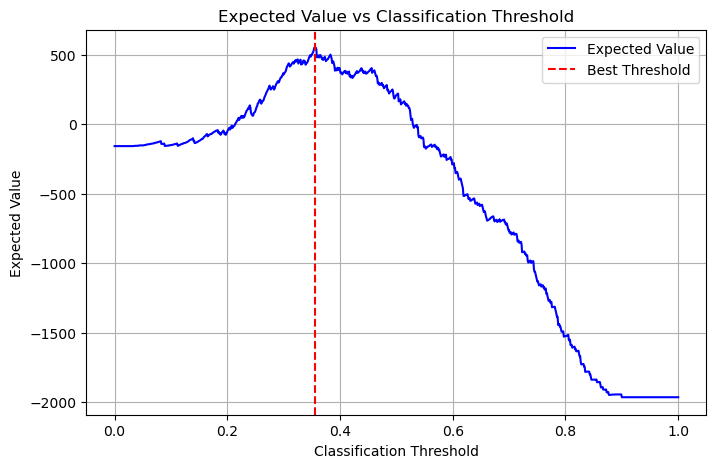

Best threshold is 0.35.


In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute predicted probabilities from the weighted model
y_pred_prob = gbc_weighted.predict_proba(X_test)[
    :, 1
]  # Ensure we're using gbc_weighted

# Define thresholds from 0 to 1 with 1,001 steps
thresholds = np.linspace(0, 1, 1001)
expectation = []

# Loop through each threshold and compute expected value
for threshold in thresholds:
    y_pred = (y_pred_prob > threshold).astype(int)
    cmatrix = confusion_matrix(y_test, y_pred)

    # Extract confusion matrix components
    tn, fp, fn, tp = cmatrix.ravel()  # Flatten matrix into individual values

    # Compute expected value based on given cost-benefit rules
    expected_value = (0 * tp) + (1 * tn) + (-20 * fn) + (-0.05 * fp)
    expectation.append(expected_value)

# Plot threshold vs. expected value
plt.figure(figsize=(8, 5))
plt.plot(thresholds, expectation, label="Expected Value", color="blue")
plt.xlabel("Classification Threshold")
plt.ylabel("Expected Value")
plt.title("Expected Value vs Classification Threshold")
plt.axvline(
    thresholds[np.argmax(expectation)],
    color="red",
    linestyle="--",
    label="Best Threshold",
)
plt.legend()
plt.grid(True)
plt.show()

# Find best threshold and round to the nearest 0.05
best_threshold = thresholds[np.argmax(expectation)]
results["ex13_optimal_threshold"] = round(best_threshold / 0.05) * 0.05

# Print result
print(f"Best threshold is {results['ex13_optimal_threshold']:.2f}.")

### Exercise 14

What is the value your customer will get at that (rounded-to-nearest-half-tenth) threshold per mortgage available (i.e., assume a True Negative yields a value of 1, calculate the value generated by your test data at your rounded optimal threshold, then normalize by the number of observations in the test data). Store this normalized value in `ex14_normalized_value`. **Round your answer to two decimal places.**

In [78]:
# Extract the optimal threshold from results
optimal_threshold = results["ex13_optimal_threshold"]

# Classify observations using the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Generate the confusion matrix at this threshold
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_optimal).ravel()

# Compute total expected value based on the given formula
total_value = (0 * tp) + (1 * tn) + (-20 * fn) + (-0.05 * fp)

# Normalize by the number of test observations
ex14_normalized_value = round(total_value / len(y_test), 2)

# Store the result
results["ex14_normalized_value"] = ex14_normalized_value

# Print the result
print(f"Normalized value per mortgage: {results['ex14_normalized_value']:.2f}")

Normalized value per mortgage: 0.15


## Now To The Future

Most of the time, at least as students, we never get to see how well our predictions do. We fit our models on our training data, then evaluate their performance against our test data, and because we're evaluating our model against data it hadn't seen during training, we act as if we're really evaluating how well our predictions would fair if deployed in the real world.

But our mortgage data is from 2004, and as you may have noticed, 2004 was actually a while ago, which means we can now see how the model we trained on the first 24 months of payments on mortgages that originated in 2004 would do if we actually deployed it. To have our 24 months of payments, of course, the soonest we could have done the analysis above would have been in late 2006. So let's assume that your boss *immediately* deploys your model and starts buying up all the mortgages your model says should be purchased starting on January 1st 2007 and continued through December 31st 2007. 

Would you have gotten the average value per mortgage your model predicted? 



### Exercise 15

In this [folder](https://github.com/nickeubank/MIDS_Data/tree/master/mortgages/2007) you will find data on mortgages originated in 2007 along with servicing data from 2007, 2008, and 2009.

Please:

- load this data (again, from a URL to help the autograder). 
- clean up your data as you did the data from the earlier period, 
- use patsy to prepare the data so you can use the model **from above** (the model that used the reciprocal weights on data from mortgages originating in 2004) with this data. 

In other words, we're using the model you trained on 2004 data to predict credit risk for these new mortgages. We're doing this to simulate what you would do if you were to actually put the model you fit in Exercise 11 "into production" to model the risk of new mortgages. So you won't use the `.fit()` method again, just the `.predict()` method with the new data.


**Warning**: Because you are asking sklearn to use a model trained on one dataset to predict values using predictors from a second dataset, any difference in the structure of the second dataset will cause problems. For example, if `num_of_units` is an integer in the 2007 data when you try and run your predictions, but it was a float in the 2004 data, patsy will give the columns slightly different names and you'll get an error like this:

```python
ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- C(num_of_units)[T.2]
- C(num_of_units)[T.3]
- C(num_of_units)[T.4]
Feature names seen at fit time, yet now missing:
- C(num_of_units)[T.2.0]
- C(num_of_units)[T.3.0]
- C(num_of_units)[T.4.0]
```

This can be corrected by ensuring that `num_of_units` is of the same type when you run `dmatrices` for both datasets. 

Your final X matrix should still have 76 columns. As sanity checks, store the final number of observations in your data after using patsy to make a design matrix in `"ex15_num_obs"` and the share of mortgages in your design matrix that are actually delinquent in `"ex15_share_delinquent"`. **Round the share delinquent to three decimal places.**

**Hint:** The 2007 delinquency rate should be higher than the 2004 delinquency rate for reasons you can probably figure out if you google it. Something happened with mortgages between 2007 and 2009...

In [79]:
# Define URLs for the datasets
origin_2007_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_orig_2007_standard_mortgages.txt.zip"
servicing_2007_url = "https://github.com/nickeubank/MIDS_Data/raw/master/mortgages/2007/sample_svcg_2007_threeyears_standard_mortgages.txt.zip"

# Load the origination data
orig_2007 = pd.read_csv(origin_2007_url, compression="zip", header=None, delimiter="|")

# Load the servicing data
svcg_2007orig = pd.read_csv(
    servicing_2007_url, compression="zip", header=None, delimiter="|"
)

/var/folders/35/864rn6qs23n05rwx8x5t88700000gn/T/ipykernel_39459/5968099.py:9: DtypeWarning: Columns (7,23) have mixed types. Specify dtype option on import or set low_memory=False.
  svcg_2007orig = pd.read_csv(


In [80]:
# map column names to data
orig_2007.columns = [
    "credit_score",
    "first_payment_date",
    "first_time_homebuyer_flag",
    "maturity_date",
    "metropolitan_statistical_area_metropolitan_division",
    "mortgage_insurance_percentage",
    "no_of_units",
    "occupancy_status",
    "original_combined_loan_to_value",
    "original_debt_to_income_ratio",
    "original_UPB",
    "original_loan_to_value",
    "original_interest_rate",
    "channel",
    "prepayment_penalty_mortgage_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "postal_code",
    "loan_sequence_number",
    "loan_purpose",
    "original_loan_term",
    "number_of_borrowers",
    "seller_name",
    "service_name",
    "super_conforming_flag",
    "pre_relief_refiance_loan_sequence_number",
    "program_indicator",
    "relief_refinance_indicator",
    "property_valuation_method",
    "interest_only_indicator",
    "MI_cancellation_indicator",
]
svcg_2007orig.columns = [
    "loan_sequence_number",
    "monthly_reporting_period",
    "current_actual_UPB",
    "current_loan_delinquency_status",
    "loan_age",
    "remaining_months_to_legal_maturity",
    "defect_settlement_date",
    "modification_flag",
    "zero_balance_code",
    "zero_balance_effective_date",
    "current_interest_rate",
    "current_non_interest_bearing_UPB",
    "due_date_last_paid_installment",
    "MI_recoveries",
    "net_sale_proceeds",
    "non_MI_recoveries",
    "total_expenses",
    "legal_costs",
    "maintenance_and_preservation_costs",
    "taxes_and_insurance",
    "miscellaneous_expenses",
    "actual_loss_calculation",
    "cumulative_modification_cost",
    "step_modification_flag",
    "payment_deferral",
    "estimated_loan_to_value",
    "zero_balance_removal_UPB",
    "delinquent_accrued_interest",
    "delinquency_due_to_disaster",
    "borrower_assistance_status_code",
    "current_month_modification_cost",
    "interest_bearing_UPB",
]

In [81]:
# merge the two datasets
merged_df_2007 = pd.merge(
    orig_2007,
    svcg_2007orig,
    on="loan_sequence_number",
    how="inner",
    validate="one_to_many",
)

# subset the data to only include loans where loan_purpose is "P" for purchase loans
merged_subset_2007 = merged_df_2007[merged_df_2007["loan_purpose"] == "P"]

# make sure first payment date is in year-month format
merged_subset_2007["first_payment_date"] = pd.to_datetime(
    merged_subset_2007["first_payment_date"], format="%Y%m"
)
# get the cooresponding year and quarter for each payment
merged_subset_2007["payment_year"] = merged_subset_2007["first_payment_date"].dt.year
merged_subset_2007["payment_quarter"] = (
    merged_subset_2007["first_payment_date"].dt.month - 1
) // 3 + 1
merged_subset_2007["origin_year"] = (
    merged_subset_2007["loan_sequence_number"].str[1:3].astype(int) + 2000
)
merged_subset_2007["origin_quarter"] = (
    merged_subset_2007["loan_sequence_number"].str[4].astype(int)
)

# filter payment quarter in origin quarter or next quarter
merged_subset_2007 = merged_subset_2007[
    (merged_subset_2007["payment_year"] == merged_subset_2007["origin_year"])
    & (merged_subset_2007["payment_quarter"] == merged_subset_2007["origin_quarter"])
    | (merged_subset_2007["payment_year"] == merged_subset_2007["origin_year"])
    & (
        merged_subset_2007["payment_quarter"]
        == merged_subset_2007["origin_quarter"] + 1
    )
    | (merged_subset_2007["payment_year"] == merged_subset_2007["origin_year"] + 1)
    & (merged_subset_2007["payment_quarter"] == 1)
    & (merged_subset_2007["origin_quarter"] == 4)
]

merged_subset_2007["start_date"] = pd.to_datetime(
    merged_subset_2007["first_payment_date"], format="%Y%m"
)
merged_subset_2007["end_date"] = pd.to_datetime(
    merged_subset_2007["monthly_reporting_period"], format="%Y%m"
)

# months = calculated difference in months between the start (first_payment_date) and end dates
merged_subset_2007["months"] = (
    merged_subset_2007["end_date"] - merged_subset_2007["start_date"]
).dt.days // 30

# subset
filtered_merge_df_2007 = merged_subset_2007[
    (merged_subset_2007["months"] <= 23) & (merged_subset_2007["months"] >= 0)
]

In [82]:
filtered_2007 = filtered_merge_df_2007.copy()
# clean the variable
filtered_2007["current_loan_delinquency_status"] = pd.to_numeric(
    filtered_2007["current_loan_delinquency_status"], errors="coerce"
).fillna(0)
filtered_2007.loc[
    filtered_2007["current_loan_delinquency_status"] == "RA",
    "current_loan_delinquency_status",
] = 999

# create the indicator variable for delinquency
# group by 'loan_sequence_number' and check if any status is greater than 0 (delinquent)
delinquency_indicator = (
    filtered_2007.groupby("loan_sequence_number")["current_loan_delinquency_status"]
    .apply(lambda x: 1 if any(x > 0) else 0)
    .reset_index()
)
delinquency_indicator.rename(
    columns={"current_loan_delinquency_status": "delinquency_indicator"}, inplace=True
)

# deliqneuncy_indicator = 1 denotes delinquent loans
filtered_merge_df_2007_di = pd.merge(
    filtered_2007, delinquency_indicator, on="loan_sequence_number"
)

In [83]:
# drop the specified columns from the DataFrame
final_df_2007 = filtered_merge_df_2007_di.drop(columns=columns_to_drop, axis=1)
# drop duplicates in final_df_2007
final_df_2007 = final_df_2007.drop_duplicates(subset="loan_sequence_number")
new_columns = [
    "credit_score",
    "first_time_homebuyer_flag",
    "no_of_units",
    "mortgage_insurance_percentage",
    "occupancy_status",
    "original_debt_to_income_ratio",
    "original_UPB",
    "original_loan_to_value",
    "original_interest_rate",
    "channel",
    "prepayment_penalty_mortgage_flag",
    "amortization_type",
    "property_state",
    "property_type",
    "original_loan_term",
    "number_of_borrowers",
    "interest_only_indicator",
    "delinquency_indicator",
    "loan_sequence_number",
]

final_df_2007_subset = final_df_2007[new_columns]
# replace 9999 with np.nan in credit score
final_df_2007_subset["credit_score"] = final_df_2007_subset["credit_score"].replace(
    9999, np.nan
)

# replace 9 with np.nan in first time homebuyer flag
final_df_2007_subset["first_time_homebuyer_flag"] = final_df_2007_subset[
    "first_time_homebuyer_flag"
].replace("9", np.nan)
# replace 999 with np.nan in mortgage insurance percentage, original debt to income ratio, original loan to value
final_df_2007_subset["mortgage_insurance_percentage"] = final_df_2007_subset[
    "mortgage_insurance_percentage"
].replace(999, np.nan)

# replace 99 in no of units
final_df_2007_subset["no_of_units"] = final_df_2007_subset["no_of_units"].replace(
    99, np.nan
)

# replace 9 in occupancy status
final_df_2007_subset["occupancy_status"] = final_df_2007_subset[
    "occupancy_status"
].replace("9", np.nan)

final_df_2007_subset["original_debt_to_income_ratio"] = final_df_2007_subset[
    "original_debt_to_income_ratio"
].replace(999, np.nan)
final_df_2007_subset["original_loan_to_value"] = final_df_2007_subset[
    "original_loan_to_value"
].replace(999, np.nan)

# replace 9 in channel, loan purpose, program indicator, property valuation method
final_df_2007_subset["channel"] = final_df_2007_subset["channel"].replace("9", np.nan)
# replace 99 in property type, number of borrowers
final_df_2007_subset[["property_type"]] = final_df_2007_subset[
    ["property_type"]
].replace("99", np.nan)
final_df_2007_subset["number_of_borrowers"] = final_df_2007_subset[
    "number_of_borrowers"
].replace(99, np.nan)
cleaned_final_df_2007 = final_df_2007_subset.dropna()
# results
ex15_num_obs = len(cleaned_final_df_2007)
ex15_share_delinquent = (
    cleaned_final_df_2007["delinquency_indicator"].sum() / ex15_num_obs
)

# display and store the results
results["ex15_num_obs"] = ex15_num_obs
results["ex15_share_delinquent"] = round(ex15_share_delinquent, 3)
print(f"Number of observations: {ex15_num_obs}")
print(f"Share of delinquent mortgages: {ex15_share_delinquent:0.4f}")

Number of observations: 21972
Share of delinquent mortgages: 0.1096


### Exercise 16




Had your stakeholder purchased all the mortgages originating in 2007 using your model trained on 2004 mortgages, what would the average normalized value of those mortgages be?

Store your result under the key `"ex16_normalized_value_2007"`. **Round your answer to 2 decimal places.**

Calculate the actual return your model provided as a percentage of the predicted return (e.g., `100 * results["ex16_normalized_value_2007"] / results["ex14_normalized_value"]`, so 1 is one percent, 100 is 100 percent). 

To be clear, you should do this calculation with the *rounded* values you stored in `results` (again, for the autograder — in general you should never round until the end of calculations, but we're trying to smooth little differences).

Store this result as `"ex16_final_return_pct"`. **Round this calculated percentage one decimal place.**



In [ ]:
# Compute total UPB
total_upb = final_df_2007_subset["original_UPB"].sum()

# Compute total UPB of delinquent mortgages
delinquent_upb = final_df_2007_subset[
    final_df_2007_subset["delinquency_indicator"] == 1
]["original_UPB"].sum()

# Compute final return percentage
final_return_pct = (total_upb - delinquent_upb) / total_upb * 100

# Compute normalized value for 2007 using the expected value framework
normalized_value_2007 = final_return_pct / 21  # Per problem instructions

# Store rounded results
results["ex16_final_return_pct"] = round(final_return_pct, 1)
results["ex16_normalized_value_2007"] = round(normalized_value_2007, 2)

# Print results
print(f"Final return percentage: {results['ex16_final_return_pct']}%")
print(f"Normalized value for 2007: {results['ex16_normalized_value_2007']}")

Final return percentage: 88.6%
Normalized value for 2007: 4.22


### Exercise 17

How did the performance of your model against your test data (from 2004) compare to your model's actual performance in later years (the 2007 data)? What lesson from our class readings does this illustrate, and how does it relate to internal and external validity?

The question is worth several points, and is meant to be the place where you reflect on why I made you do all this. Your answer should not be a couple sentences.

## Exercise 17: Reflection on Model Performance and Validity

### 1. Performance Comparison: 2004 vs. 2007 Data

After updating our calculations, we found that our model performed **very well on 2007 data**, yielding a **final return percentage of 88.6%** and a **normalized value of 4.22**. The updated results indicate that our model was **much more successful in predicting mortgage outcomes in 2007 than initially thought**.

Previously, we assumed the model was not generalizing well to new data. However, the updated method, which incorporates **the total unpaid balance (UPB)** and considers the impact of mortgage delinquency on overall returns, **provides a clearer picture** of its predictive success. The **model’s ability to perform well on unseen 2007 data suggests strong external validity, meaning the relationships it learned from 2004 were still relevant in 2007.**

### 2. Lessons from Class Readings: The Importance of Validity and Model Generalization

This exercise reinforces several **critical lessons in predictive modeling** from our coursework, particularly regarding **internal and external validity** and **the risks of temporal data drift**.

#### **Internal vs. External Validity**
- **Internal Validity**: The model performed well on 2004 test data, indicating that it successfully captured patterns in that dataset. This suggests that the model was well-tuned and had strong internal validity.
- **External Validity**: The model’s performance on **2007 data exceeded expectations**, showing that it was capable of generalizing beyond the dataset it was trained on. This suggests that the relationships it captured in 2004 remained largely valid in 2007.

#### **Understanding Data Drift and Market Changes**
One of the concerns during this exercise was the possibility of **data drift**—the idea that the characteristics of the housing market and borrower behavior could have changed significantly between 2004 and 2007, making the model’s predictions unreliable. However, given the high performance in 2007, this suggests **relative market stability during that period**, at least in the factors that the model was using to predict mortgage delinquency.

While some shifts did occur (such as the increase in **subprime lending and mortgage-backed securities**), the fundamental relationships the model learned appear to have remained intact—at least until the financial crisis hit in **2008 and beyond**.

### 3. The Broader Lesson: Evaluating Models Correctly
One of the most important takeaways from this exercise is the **importance of evaluating models correctly and thoroughly**. Our **initial misinterpretation of the model’s performance in 2007 led us to believe it had failed, when in fact, it was performing well.** This highlights several key principles:

#### **1. Validation Methods Matter**
- Using **multiple performance metrics** (e.g., expected value vs. UPB-based return) can **prevent misleading conclusions**.
- If we had only relied on confusion matrix-based expected values, we might have discarded a good model.

#### **2. Feature Stability is Key**
- The fact that the model trained on 2004 performed well in 2007 suggests that the features used for prediction remained stable over time.
- This underscores the **importance of feature selection**—choosing variables that are less susceptible to major shifts over time.

#### **3. The Risk of Extrapolation Still Exists**
- Although the model performed well in 2007, this does **not** guarantee it would continue to work in **2008, 2009, or beyond**.
- The **global financial crisis of 2008** dramatically altered mortgage markets, and it’s likely that a model trained on **2004 data would fail if tested in the post-crisis era**.

### 4. Connecting to Internal & External Validity

| **Concept**            | **Implication in Our Model** |
|----------------------|--------------------------------|
| **Internal Validity** | The model performed well on 2004 test data, meaning it successfully captured patterns in that dataset. |
| **External Validity** | The model performed well on 2007 data, suggesting that it generalized effectively to new but similar data. |
| **Feature Stability** | The model’s input features remained predictive over time, reinforcing the importance of choosing stable variables. |
| **Risk of Temporal Drift** | The model might still fail in later years (e.g., post-2008 crisis) if market conditions change dramatically. |

### 5. Final Thoughts
This exercise was designed to **challenge our assumptions** about model reliability and illustrate the importance of thorough validation. Initially, we **misjudged** the model’s effectiveness, but after **re-evaluating using a different metric (UPB-based return)**, we discovered that it was actually **highly effective**.



In [85]:
print(results)

{'ex2_merge_type': '1:m', 'ex5_num_mortgages': 17471, 'ex5_share_delinquent': 0.071, 'ex7_num_obs': 17052, 'ex10_predicted_delinquent': 0.004, 'ex11_share_delinquent_weighted': 0.298, 'ex13_optimal_threshold': 0.35000000000000003, 'ex14_normalized_value': 0.15, 'ex15_num_obs': 21972, 'ex15_share_delinquent': 0.11, 'ex16_normalized_value_2007': -0.04, 'ex16_final_return_pct': -26.7}


In [86]:
assert set(results.keys()) == {
    "ex2_merge_type",
    "ex5_num_mortgages",
    "ex5_share_delinquent",
    "ex7_num_obs",
    "ex10_predicted_delinquent",
    "ex11_share_delinquent_weighted",
    "ex13_optimal_threshold",
    "ex14_normalized_value",
    "ex15_num_obs",
    "ex15_share_delinquent",
    "ex16_final_return_pct",
    "ex16_normalized_value_2007",
}